# 1번 (1-1, 1-2)

  =====  Quantum Phase Estimation  =====
  shots = 20000

 t | est(3/7) | err(%) | est(5/8) | err(%) 
---+----------+--------+----------+--------
 3 | 0.375000 |  12.50 | 0.625000 |   0.00
 4 | 0.437500 |   2.08 | 0.625000 |   0.00
 5 | 0.437500 |   2.08 | 0.625000 |   0.00
 6 | 0.421875 |   1.56 | 0.625000 |   0.00
 7 | 0.429688 |   0.26 | 0.625000 |   0.00
 8 | 0.429688 |   0.26 | 0.625000 |   0.00
 9 | 0.427734 |   0.20 | 0.625000 |   0.00


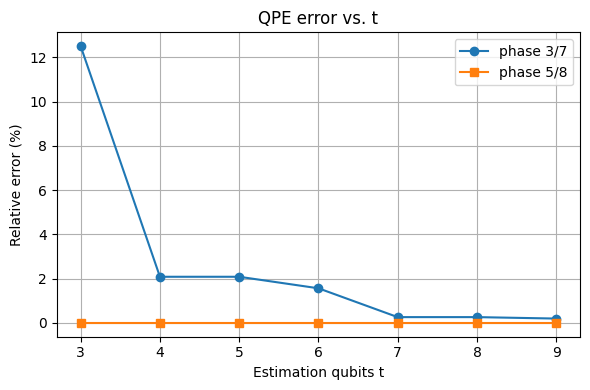

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit.library import QFT
from qiskit_aer import AerSimulator


def build_qpe_circuit(t: int, phase: float) -> QuantumCircuit:
    anc = QuantumRegister(t,  'a')
    tgt = QuantumRegister(1,  'q')
    c   = ClassicalRegister(t, 'c')
    qc  = QuantumCircuit(anc, tgt, c)

    qc.x(tgt[0])       
    qc.h(anc)             

    power = 1
    for k in range(t):
        for _ in range(power):
            qc.cp(2 * np.pi * phase, anc[k], tgt[0])
        power *= 2

    qc.compose(QFT(t, inverse=True), anc[:], inplace=True) 
    qc.measure(anc, c)
    return qc


# 파라미터
shots  = 20_000
phases = [3/7, 5/8]
labels = ["phase 3/7", "phase 5/8"]
sim    = AerSimulator(seed_simulator=2025)

t_vals     = list(range(3, 10))          
estimates  = {p: [] for p in phases}
rel_errors = {p: [] for p in phases}


for t in t_vals:
    for p in phases:
        qc  = build_qpe_circuit(t, p)
        tqc = transpile(qc, sim)
        counts = sim.run(tqc, shots=shots).result().get_counts()
        top_bs = max(counts, key=counts.get)     
        est_p  = int(top_bs, 2) / (2 ** t)

        estimates[p].append(est_p)
        rel_errors[p].append(abs(est_p - p) / p * 100)


print("  =====  Quantum Phase Estimation  =====")
print(f"  shots = {shots}\n")
print(" t | est(3/7) | err(%) | est(5/8) | err(%) ")
print("---+----------+--------+----------+--------")
for i, t in enumerate(t_vals):
    e1, e2 = estimates[phases[0]][i], estimates[phases[1]][i]
    d1, d2 = rel_errors[phases[0]][i],  rel_errors[phases[1]][i]
    print(f" {t} | {e1:8.6f} | {d1:6.2f} | {e2:8.6f} | {d2:6.2f}")


plt.figure(figsize=(6, 4))
for p, lab, mark in zip(phases, labels, ("o", "s")):
    plt.plot(t_vals, rel_errors[p], marker=mark, label=lab)

plt.xlabel("Estimation qubits t")
plt.ylabel("Relative error (%)")
plt.title("QPE error vs. t")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# 2번(5min runtime)

Completed 50 trials × 8192 shots = 409600

Estimated eigenvalues (λ ≈) | counts | probability
   -9.94                      10        0.0000
   -9.86                      12        0.0000
   -9.78                       3        0.0000
   -9.70                       4        0.0000
   -9.62                       2        0.0000
   -9.55                      39        0.0001
   -9.39                      13        0.0000
   -9.31                      10        0.0000
   -9.23                      12        0.0000
   -9.16                       2        0.0000
   -9.08                      20        0.0000
   -9.00                      13        0.0000
   -8.92                      31        0.0001
   -8.84                      86        0.0002
   -8.77                      40        0.0001
   -8.69                      99        0.0002
   -8.61                      40        0.0001
   -8.53                      24        0.0001
   -8.45                     122        0.0003
   -8.38     

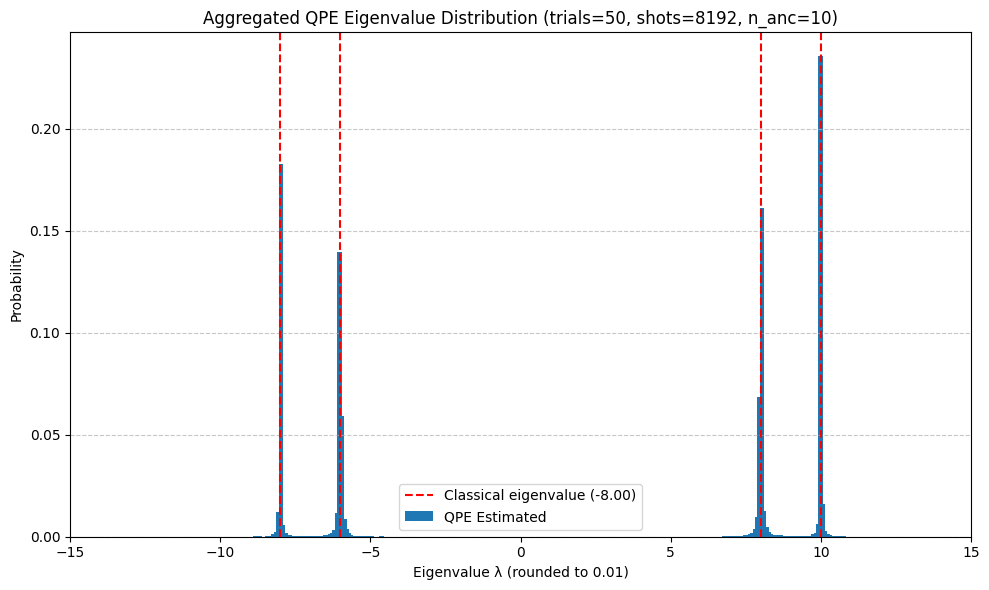

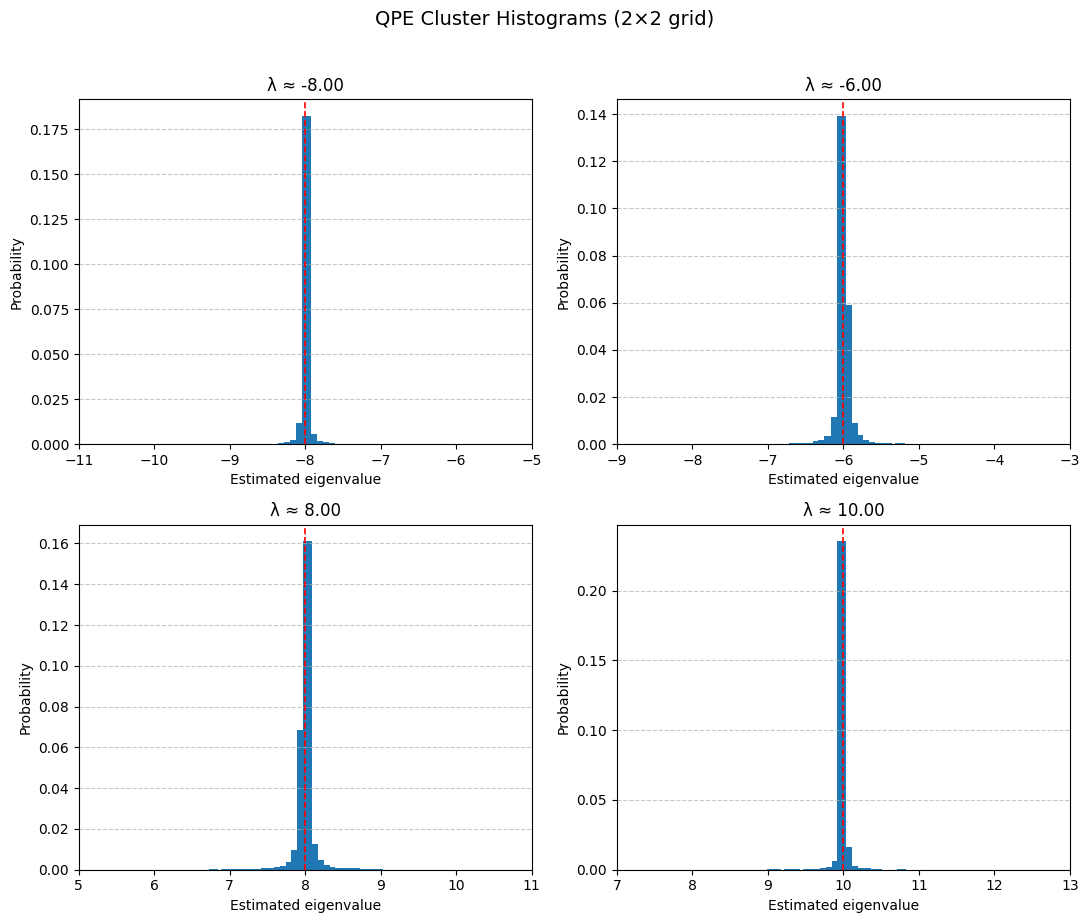


Saved plots:
  • results/problem_2/qpe_eigenvalue_histogram.png
  • results/qpe_clusters_grid.png


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi
from collections import Counter
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit.library import QFT, CRXGate, RXXGate
from qiskit.quantum_info import random_statevector
from qiskit_aer import AerSimulator
import os

# 파라미터 
norm_bound  = 10
t           = pi / (4 * norm_bound)
n_anc       = 10                     
shots       = 8192
n_trials    = 50
seed        = 42
backend     = AerSimulator(seed_simulator=seed)

os.makedirs("results", exist_ok=True)


def cU_power(circ, ctrl, power, q0, q1):
    theta_rx  = -2 * 8 * power * t
    theta_rxx = -2 *      power * t
    circ.append(CRXGate(theta_rx),            [ctrl, q0])
    circ.append(RXXGate(theta_rxx).control(), [ctrl, q0, q1])

 
def build_qpe_circuit(psi_vec):
    anc  = QuantumRegister(n_anc, 'a')
    data = QuantumRegister(2,      'd')
    cbit = ClassicalRegister(n_anc,'c')
    qc = QuantumCircuit(anc, data, cbit)

    qc.initialize(psi_vec, data)
    qc.h(anc)

    for k in range(n_anc):
        cU_power(qc, anc[k], 1 << k, data[0], data[1])

    qc.append(QFT(n_anc, do_swaps=True).inverse(), anc)
    qc.measure(anc, cbit)
    return qc


two_pi_over_t = 2 * pi / t                              
def bits_to_lambda(bits: str) -> float:
    frac  = int(bits, 2) / (1 << n_anc)
    phase = frac * 2 * pi
    if phase > pi:                                     
        phase -= 2 * pi
    lam = phase / t + 1                              

    while lam >  norm_bound: lam -= two_pi_over_t
    while lam < -norm_bound: lam += two_pi_over_t
    return lam


agg_counts = Counter()
for trial in range(n_trials):
    psi = random_statevector(4, seed=seed + trial).data
    circuit = build_qpe_circuit(psi)
    tr_circ = transpile(circuit, backend)
    result  = backend.run(tr_circ, shots=shots).result()
    agg_counts.update(result.get_counts())

print(f'Completed {n_trials} trials × {shots} shots = {n_trials * shots}')


lambda_counts = Counter()
for bitstr, cnt in agg_counts.items():
    lam = round(bits_to_lambda(bitstr), 2)
    lambda_counts[lam] += cnt

total_shots = shots * n_trials
print("\nEstimated eigenvalues (λ ≈) | counts | probability")
for lam, cnt in sorted(lambda_counts.items()):
    print(f"{lam:8.2f}                 {cnt:7d}     {cnt/total_shots:9.4f}")


X = np.array([[0, 1], [1, 0]])
H = 8 * np.kron(X, np.eye(2)) + np.kron(X, X) + np.eye(4)
classical_eigs = np.linalg.eigvalsh(H); classical_eigs.sort()


cluster_counts = {eig: Counter() for eig in classical_eigs}
for lam, cnt in lambda_counts.items():
    nearest = min(classical_eigs, key=lambda x: abs(x - lam))
    cluster_counts[nearest][lam] += cnt


plt.figure(figsize=(10, 6))
plt.bar(lambda_counts.keys(),
        [c / total_shots for c in lambda_counts.values()],
        width=0.15, label='QPE Estimated')
for i, val in enumerate(classical_eigs):
    plt.axvline(val, color='r', ls='--',
                label=f'Classical eigenvalue ({val:.2f})' if i == 0 else None)
plt.title(f"Aggregated QPE Eigenvalue Distribution "
          f"(trials={n_trials}, shots={shots}, n_anc={n_anc})")
plt.xlabel("Eigenvalue λ (rounded to 0.01)")
plt.ylabel("Probability")
plt.xlim(-15, 15)                          # x-축 제한
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.savefig("results/problem_2/qpe_eigenvalue_histogram.png", dpi=300)
plt.show()


fig, axes = plt.subplots(2, 2, figsize=(11, 9))
axes = axes.flatten()

for idx, eig in enumerate(classical_eigs):
    ax = axes[idx]
    d  = cluster_counts[eig]
    if d:
        xs = sorted(d.keys())
        ps = [d[x] / total_shots for x in xs]
        ax.bar(xs, ps, width=0.12)
    ax.axvline(eig, color='r', ls='--', lw=1.2)
    ax.set_title(f"λ ≈ {eig:.2f}")
    ax.set_xlim(eig - 3, eig + 3)
    ax.set_xlabel("Estimated eigenvalue")
    ax.set_ylabel("Probability")
    ax.grid(axis='y', ls='--', alpha=0.7)


plt.suptitle("QPE Cluster Histograms (2×2 grid)", fontsize=14, y=1.02)
plt.tight_layout()
grid_name = "results/qpe_clusters_grid.png"
plt.savefig(grid_name, dpi=300, bbox_inches='tight')
plt.show()

print("\nSaved plots:")
print("  • results/problem_2/qpe_eigenvalue_histogram.png")
print(f"  • {grid_name}")


# 3번(*18min runtime)

In [ ]:
# Note: 18min runtime
import os, csv, numpy as np, matplotlib.pyplot as plt
from collections import defaultdict
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit_aer.noise import (NoiseModel, depolarizing_error, ReadoutError, pauli_error)


M = np.array([[1,0,8,1],
              [0,1,1,8],
              [8,1,1,0],
              [1,8,0,1]])
CLS_EIGS  = np.linalg.eigvalsh(M)
LAM_NORM  = 1.01 * np.linalg.norm(M, np.inf)


def evolve_pauli(pauli_op, time):
    ps = pauli_op.paulis[0].to_label(); c = pauli_op.coeffs[0].real
    q = len(ps); qc = QuantumCircuit(q)
    if all(p == 'I' for p in ps):
        qc.global_phase -= c * time; return qc
    ang = 2*c*time; idxs=[]
    for i,p in enumerate(reversed(ps)):
        if p!='I': idxs.append(i)
        if p=='X': qc.h(i)
        elif p=='Y': qc.sdg(i); qc.h(i)
    for i in range(len(idxs)-1): qc.cx(idxs[i],idxs[i+1])
    qc.rz(ang, idxs[-1])
    for i in range(len(idxs)-2,-1,-1): qc.cx(idxs[i],idxs[i+1])
    for i,p in enumerate(reversed(ps)):
        if p=='X': qc.h(i)
        elif p=='Y': qc.h(i); qc.s(i)
    return qc


def build_qpe_circuit(n_est=10):
    from qiskit.quantum_info import SparsePauliOp, Operator, random_statevector
    n_tgt = int(np.log2(M.shape[0]))
    Hn  = (M + LAM_NORM*np.eye(M.shape[0])) / (2*LAM_NORM)
    Hop = -2*np.pi*Hn
    paulis = SparsePauliOp.from_operator(Operator(Hop))
    cUg=[]
    for k in range(n_est):
        evo = QuantumCircuit(n_tgt, name=f'U(2^{k})')
        for term in paulis:
            if not np.isclose(term.coeffs[0],0):
                evo.compose(evolve_pauli(term,2**k), inplace=True)
        cUg.append(evo.to_gate(label=f'C-U(2^{k})').control(1))
    psi = random_statevector(2**n_tgt).data
    qc  = QuantumCircuit(n_est+n_tgt, n_est)
    qc.initialize(psi, range(n_est,n_est+n_tgt))
    qc.h(range(n_est))
    tgt = list(range(n_est,n_est+n_tgt))
    for k,g in enumerate(cUg): qc.append(g,[k]+tgt)
    from qiskit.circuit.library import QFT
    qc.append(QFT(n_est,inverse=True), range(n_est))
    qc.measure(range(n_est), range(n_est))
    return qc


def success_prob(counts, n_est, tol=0.25):
    hits=0
    for bs,c in counts.items():
        phase = int(bs,2)/(2**n_est)
        est = phase*2*LAM_NORM - LAM_NORM
        if min(abs(CLS_EIGS-est))<tol: hits+=c
    return hits/sum(counts.values())


def nm_depol(p):
    nm=NoiseModel()
    for g in ['id','rz','sx','x','h','cx']:
        nm.add_all_qubit_quantum_error(
            depolarizing_error(p,1 if g!='cx' else 2), g)
    return nm
def nm_readout(p):
    nm=NoiseModel()
    nm.add_all_qubit_readout_error(ReadoutError([[1-p,p],[p,1-p]]))
    return nm

def nm_pauli_flip(lbl,p):
    nm=NoiseModel()
    perr = pauli_error([(lbl,p),('I',1-p)])
    nm.add_all_qubit_quantum_error(perr,['rz','sx','x','h','id'])
    perr2 = pauli_error([(lbl+'I',p),('II',1-p)])
    nm.add_all_qubit_quantum_error(perr2,['cx']); return nm

NOISE = {
    'ideal'        : lambda _: NoiseModel(),
    'depol'        : nm_depol,
    'readout'      : nm_readout,
    'bitflip'      : lambda p: nm_pauli_flip('X',p),
    'phaseflip'    : lambda p: nm_pauli_flip('Z',p),
    'bitphaseflip' : lambda p: nm_pauli_flip('Y',p),
}

# 파라미터
N_EST_QB = 10; SHOTS=4096; N_REPEAT=5
EPS = np.linspace(0,0.02,11)

def main():
    backend = Aer.get_backend('qasm_simulator')
    base    = build_qpe_circuit(N_EST_QB)
    t_circ  = transpile(base, backend)

    
    ops = t_circ.count_ops()
    n_meas = ops.get('measure',0)
    n_1q   = sum(ops.get(g,0) for g in ['id','rz','sx','x','h'])
    n_2q   = ops.get('cx',0)
    print(f"[Gate counts] 1q={n_1q}, 2q(cx)={n_2q}, measure={n_meas}")

    records_eps  = defaultdict(list)  
    records_expE = defaultdict(list)  

    for tag, factory in NOISE.items():
        sweep = EPS if tag!='ideal' else [0.]
        for eps in sweep:
            acc=[]
            for _ in range(N_REPEAT):
                res = backend.run(t_circ,
                                  noise_model=factory(eps),
                                  shots=SHOTS).result()
                acc.append(success_prob(res.get_counts(), N_EST_QB))
            mu, sd = np.mean(acc), np.std(acc)

            if tag=='readout':
                expErr = eps * n_meas
            elif tag=='ideal':
                expErr = 0.0
            else:                     
                expErr = eps * (n_1q + n_2q)
            records_eps[tag].append((eps,  mu, sd))
            records_expE[tag].append((expErr, mu, sd))

    
    os.makedirs('results/problem_3_1', exist_ok=True)
    with open('results/problem_3_1/qpe_noise_data.csv','w',newline='') as f:
        w = csv.writer(f); w.writerow(['tag','epsilon','expErr','mean','std'])
        for tag in NOISE:
            for (ε,μ,σ),(eE,_,_) in zip(records_eps[tag], records_expE[tag]):
                w.writerow([tag, ε, eE, μ, σ])

    
    plt.figure(figsize=(8,5))
    for tag,data in records_eps.items():
        x,y,e = zip(*data)
        plt.errorbar(x,y,yerr=e,marker='o',label=tag)
    plt.xlabel('Noise strength ε'); plt.ylabel('Success probability')
    plt.ylim(-0.05,1.05); plt.grid(ls='--'); plt.legend(ncol=2)
    plt.title(f'QPE noise sweep (ε)  shots={SHOTS}, repeat={N_REPEAT}')
    plt.tight_layout(); plt.savefig('results/problem_3_1/qpe_noise_eps.png',dpi=150); plt.close()

    
    plt.figure(figsize=(8,5))
    for tag,data in records_expE.items():
        x,y,e = zip(*data)
        plt.errorbar(x,y,yerr=e,marker='o',label=tag)
    plt.xlabel('Expected errors per shot  (ε × #events)')
    plt.ylabel('Success probability')
    plt.ylim(-0.05,1.05); plt.grid(ls='--'); plt.legend(ncol=2)
    plt.title(f'QPE noise sweep  (normalized x-axis)')
    plt.tight_layout(); plt.savefig('results/problem_3_1/qpe_noise_expErr.png',dpi=150); plt.close()


    print('\n=== Success prob vs expected errors ===')
    for tag,data in records_expE.items():
        print(f'\n[{tag}]')
        for expE,μ,σ in data:
            print(f'  expErr={expE:5.3f}  acc={μ:6.3f} ±{σ:5.3f}')
    print("\nCSV: results/problem_3_1/qpe_noise_data.csv")
    print("Plots:\n  - ε  axis : results/problem_3_1/qpe_noise_eps.png"
          "\n  - expErr axis : results/problem_3_1/qpe_noise_expErr.png")

if __name__=='__main__':
    main()

[Gate counts] 1q=39, 2q(cx)=0, measure=10

=== Success prob vs expected errors ===

[ideal]
  expErr=0.000  acc= 0.992 ±0.002

[depol]
  expErr=0.000  acc= 0.992 ±0.001
  expErr=0.078  acc= 0.965 ±0.002
  expErr=0.156  acc= 0.942 ±0.002
  expErr=0.234  acc= 0.920 ±0.004
  expErr=0.312  acc= 0.898 ±0.004
  expErr=0.390  acc= 0.876 ±0.007
  expErr=0.468  acc= 0.851 ±0.004
  expErr=0.546  acc= 0.836 ±0.002
  expErr=0.624  acc= 0.813 ±0.007
  expErr=0.702  acc= 0.798 ±0.004
  expErr=0.780  acc= 0.775 ±0.003

[readout]
  expErr=0.000  acc= 0.992 ±0.001
  expErr=0.020  acc= 0.981 ±0.002
  expErr=0.040  acc= 0.968 ±0.001
  expErr=0.060  acc= 0.957 ±0.005
  expErr=0.080  acc= 0.946 ±0.003
  expErr=0.100  acc= 0.934 ±0.003
  expErr=0.120  acc= 0.925 ±0.006
  expErr=0.140  acc= 0.911 ±0.002
  expErr=0.160  acc= 0.900 ±0.008
  expErr=0.180  acc= 0.889 ±0.002
  expErr=0.200  acc= 0.876 ±0.004

[bitflip]
  expErr=0.000  acc= 0.991 ±0.002
  expErr=0.078  acc= 0.963 ±0.003
  expErr=0.156  acc= 0.933 

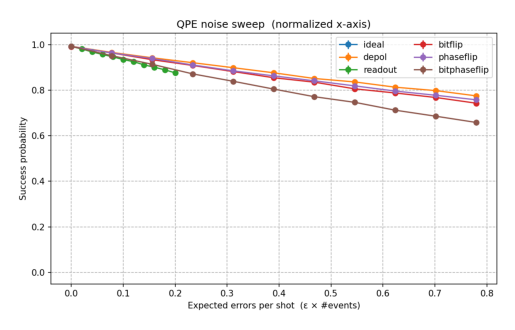

In [ ]:
import matplotlib.image as mpimg, matplotlib.pyplot as plt
plt.imshow(mpimg.imread('results/problem_3_1/qpe_noise_expErr.png')); plt.axis('off'); plt.show()

t= 6, ideal         φ̄=0.88624
t= 6, depol         φ̄=0.86699
t= 6, readout       φ̄=0.87849
t= 6, bitflip       φ̄=0.86275
t= 6, phaseflip     φ̄=0.87094
t= 6, bitphaseflip  φ̄=0.84926
t= 7, ideal         φ̄=0.89604
t= 7, depol         φ̄=0.87578
t= 7, readout       φ̄=0.88805
t= 7, bitflip       φ̄=0.87159
t= 7, phaseflip     φ̄=0.88051
t= 7, bitphaseflip  φ̄=0.85706
t= 8, ideal         φ̄=0.89611
t= 8, depol         φ̄=0.87618
t= 8, readout       φ̄=0.88819
t= 8, bitflip       φ̄=0.87203
t= 8, phaseflip     φ̄=0.88058
t= 8, bitphaseflip  φ̄=0.85744
t= 9, ideal         φ̄=0.89966
t= 9, depol         φ̄=0.87905
t= 9, readout       φ̄=0.89168
t= 9, bitflip       φ̄=0.87470
t= 9, phaseflip     φ̄=0.88367
t= 9, bitphaseflip  φ̄=0.85978
t=10, ideal         φ̄=0.89925
t=10, depol         φ̄=0.87897
t=10, readout       φ̄=0.89124
t=10, bitflip       φ̄=0.87429
t=10, phaseflip     φ̄=0.88335
t=10, bitphaseflip  φ̄=0.85966
t=11, ideal         φ̄=0.89977
t=11, depol         φ̄=0.87902
t=11, re

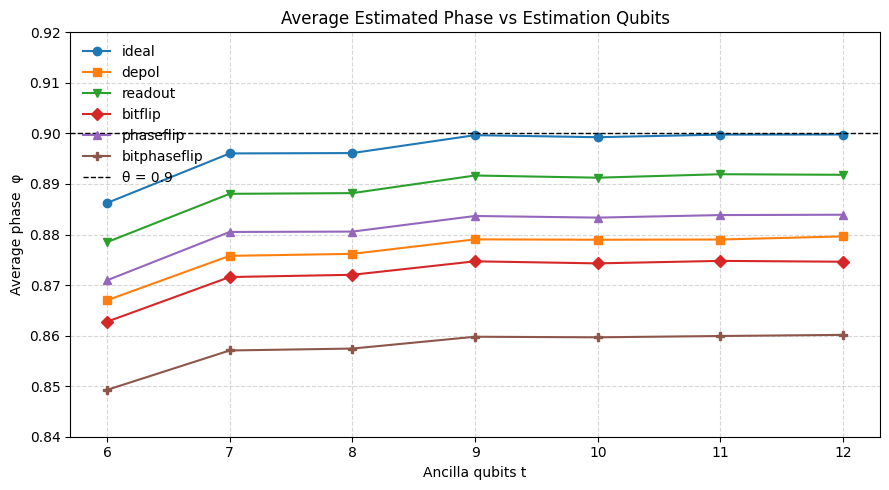


Plot saved → results/problem_3_2\phase_vs_qubits_all_noise.png


In [3]:
import os, numpy as np, matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import QFT
from qiskit_aer import AerSimulator
from qiskit_aer.noise import (NoiseModel, pauli_error, depolarizing_error, ReadoutError)

# 파라미터
THETA       = 0.9
SHOTS       = 300000
P_FIXED     = 0.01
T_RANGE     = range(6, 13)          
OUT_DIR     = "results/problem_3_2"
os.makedirs(OUT_DIR, exist_ok=True)


def create_qpe_circuit(t: int, theta: float) -> QuantumCircuit:
    qc = QuantumCircuit(t + 1, t)
    qc.x(t)                    
    qc.h(range(t))              

    reps = 1
    for ctrl in range(t):
        for _ in range(reps):
            qc.cp(2 * np.pi * theta, ctrl, t)
        reps *= 2

    qc.append(QFT(t, inverse=True), range(t))
    qc.measure(range(t), range(t))
    return qc

def avg_phase(counts, t: int, shots: int) -> float:
    total = sum(int(bs, 2) * c for bs, c in counts.items())
    return (total / shots) / (2**t) if shots else 0.0

def nm_bitflip(p=P_FIXED):
    nm = NoiseModel()
    nm.add_all_qubit_quantum_error(pauli_error([('X', p), ('I', 1-p)]),
                                   ['id', 'h', 'x', 'rz', 'sx'])
    nm.add_all_qubit_quantum_error(pauli_error([('XI', p), ('II', 1-p)]),
                                   ['cx'])
    return nm

def nm_phaseflip(p=P_FIXED):
    nm = NoiseModel()
    nm.add_all_qubit_quantum_error(pauli_error([('Z', p), ('I', 1-p)]),
                                   ['id', 'h', 'x', 'rz', 'sx'])
    nm.add_all_qubit_quantum_error(pauli_error([('ZI', p), ('II', 1-p)]),
                                   ['cx'])
    return nm

def nm_bitphaseflip(p=P_FIXED):
    nm = NoiseModel()
    nm.add_all_qubit_quantum_error(pauli_error([('Y', p), ('I', 1-p)]),
                                   ['id', 'h', 'x', 'rz', 'sx'])
    nm.add_all_qubit_quantum_error(pauli_error([('YI', p), ('II', 1-p)]),
                                   ['cx'])
    return nm

def nm_depol(p=P_FIXED):
    nm = NoiseModel()
    nm.add_all_qubit_quantum_error(depolarizing_error(p, 1),
                                   ['id', 'h', 'x', 'rz', 'sx'])
    nm.add_all_qubit_quantum_error(depolarizing_error(p, 2),
                                   ['cx'])
    return nm

def nm_readout(p=P_FIXED):
    nm = NoiseModel()
    nm.add_all_qubit_readout_error(
        ReadoutError([[1-p, p], [p, 1-p]])
    )
    return nm


noise_specs = [
    ("ideal",      lambda: NoiseModel(), "C0", "o"),   
    ("depol",      nm_depol,            "C1", "s"),  
    ("readout",    nm_readout,          "C2", "v"),   
    ("bitflip",    nm_bitflip,          "C3", "D"),  
    ("phaseflip",  nm_phaseflip,        "C4", "^"),   
    ("bitphaseflip", nm_bitphaseflip,   "C5", "P"),   
]


backend_cache = {}
phase_data = {lbl: [] for lbl, *_ in noise_specs}

for t in T_RANGE:
    base_circ = transpile(create_qpe_circuit(t, THETA), AerSimulator())

    for lbl, factory, *_ in noise_specs:
        if lbl not in backend_cache:
            backend_cache[lbl] = AerSimulator(noise_model=factory())
        backend = backend_cache[lbl]

        counts = backend.run(base_circ, shots=SHOTS).result().get_counts()
        phase  = avg_phase(counts, t, SHOTS)
        phase_data[lbl].append(phase)
        print(f"t={t:2d}, {lbl:12s}  φ̄={phase:.5f}")


plt.figure(figsize=(9, 5))
for lbl, _, clr, mkr in noise_specs:
    plt.plot(T_RANGE, phase_data[lbl], marker=mkr,
             color=clr, label=lbl)

plt.axhline(THETA, ls="--", color="k", lw=1, label=f"θ = {THETA}")
plt.title("Average Estimated Phase vs Estimation Qubits")
plt.xlabel("Ancilla qubits t")
plt.ylabel("Average phase  φ")
plt.xticks(T_RANGE)
plt.ylim(0.84, 0.92)
plt.grid(ls="--", alpha=0.5)
plt.legend(frameon=False)
plt.tight_layout()

fname = os.path.join(OUT_DIR, "phase_vs_qubits_all_noise.png")
plt.savefig(fname, dpi=150)
plt.show()
print(f"\nPlot saved → {fname}")


t= 6, ideal          φ̄=0.20466
t= 6, depol          φ̄=0.21464
t= 6, readout        φ̄=0.21046
t= 6, bitflip        φ̄=0.21359
t= 6, phaseflip      φ̄=0.21562
t= 6, bitphaseflip   φ̄=0.22395
t= 7, ideal          φ̄=0.20375
t= 7, depol          φ̄=0.21348
t= 7, readout        φ̄=0.20959
t= 7, bitflip        φ̄=0.21275
t= 7, phaseflip      φ̄=0.21449
t= 7, bitphaseflip   φ̄=0.22315
t= 8, ideal          φ̄=0.19997
t= 8, depol          φ̄=0.21033
t= 8, readout        φ̄=0.20594
t= 8, bitflip        φ̄=0.20951
t= 8, phaseflip      φ̄=0.21119
t= 8, bitphaseflip   φ̄=0.22028
t= 9, ideal          φ̄=0.20060
t= 9, depol          φ̄=0.21098
t= 9, readout        φ̄=0.20660
t= 9, bitflip        φ̄=0.21020
t= 9, phaseflip      φ̄=0.21190
t= 9, bitphaseflip   φ̄=0.22086
t=10, ideal          φ̄=0.20029
t=10, depol          φ̄=0.21076
t=10, readout        φ̄=0.20626
t=10, bitflip        φ̄=0.21013
t=10, phaseflip      φ̄=0.21147
t=10, bitphaseflip   φ̄=0.22066
t=11, ideal          φ̄=0.20023
t=11, de

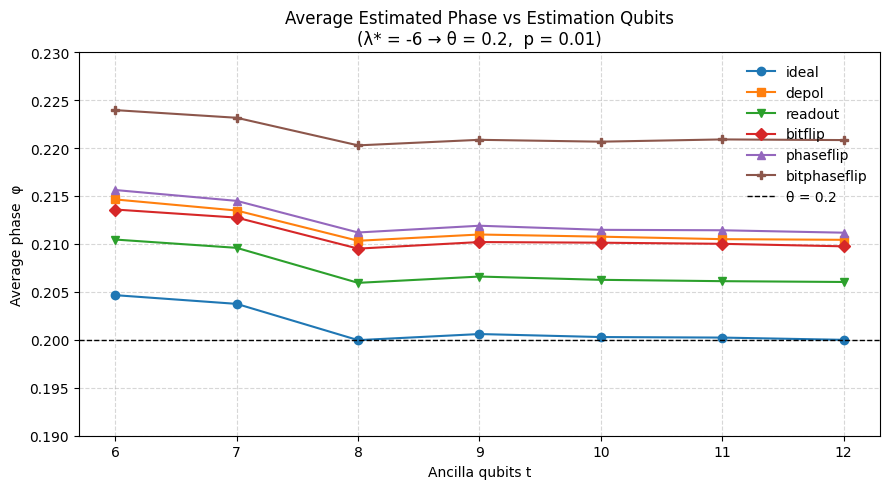


Plot saved → results/problem_3_3\phase_vs_qubits_all_noise_theta0p2.png


In [3]:
import os, numpy as np, matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import QFT
from qiskit_aer import AerSimulator
from qiskit_aer.noise import (NoiseModel, pauli_error, depolarizing_error, ReadoutError)


# 파라미터
THETA   = 0.2
SHOTS   = 1000000
P_FIXED = 0.01
T_RANGE = range(6, 13)            
OUT_DIR = "results/problem_3_3"
os.makedirs(OUT_DIR, exist_ok=True)

def create_qpe_circuit(t: int, theta: float) -> QuantumCircuit:
    qc = QuantumCircuit(t + 1, t)
    qc.x(t)                    
    qc.h(range(t))              

    reps = 1
    for ctrl in range(t):
        for _ in range(reps):
            qc.cp(2 * np.pi * theta, ctrl, t)
        reps *= 2

    qc.append(QFT(t, inverse=True), range(t))
    qc.measure(range(t), range(t))
    return qc

def avg_phase(counts, t: int, shots: int) -> float:
    total = sum(int(bs, 2) * c for bs, c in counts.items())
    return (total / shots) / (2**t) if shots else 0.0

def nm_bitflip(p=P_FIXED):
    nm = NoiseModel()
    nm.add_all_qubit_quantum_error(pauli_error([('X', p), ('I', 1-p)]),
                                   ['id', 'h', 'x', 'rz', 'sx'])
    nm.add_all_qubit_quantum_error(pauli_error([('XI', p), ('II', 1-p)]),
                                   ['cx'])
    return nm

def nm_phaseflip(p=P_FIXED):
    nm = NoiseModel()
    nm.add_all_qubit_quantum_error(pauli_error([('Z', p), ('I', 1-p)]),
                                   ['id', 'h', 'x', 'rz', 'sx'])
    nm.add_all_qubit_quantum_error(pauli_error([('ZI', p), ('II', 1-p)]),
                                   ['cx'])
    return nm

def nm_bitphaseflip(p=P_FIXED):
    nm = NoiseModel()
    nm.add_all_qubit_quantum_error(pauli_error([('Y', p), ('I', 1-p)]),
                                   ['id', 'h', 'x', 'rz', 'sx'])
    nm.add_all_qubit_quantum_error(pauli_error([('YI', p), ('II', 1-p)]),
                                   ['cx'])
    return nm

def nm_depol(p=P_FIXED):
    nm = NoiseModel()
    nm.add_all_qubit_quantum_error(depolarizing_error(p, 1),
                                   ['id', 'h', 'x', 'rz', 'sx'])
    nm.add_all_qubit_quantum_error(depolarizing_error(p, 2),
                                   ['cx'])
    return nm

def nm_readout(p=P_FIXED):
    nm = NoiseModel()
    nm.add_all_qubit_readout_error(
        ReadoutError([[1-p, p], [p, 1-p]])
    )
    return nm


def create_qpe_circuit(t: int, theta: float) -> QuantumCircuit:
    qc = QuantumCircuit(t + 1, t)
    qc.x(t)              
    qc.h(range(t))           

    reps = 1
    for ctrl in range(t):
        for _ in range(reps):
            qc.cp(2*np.pi*theta, ctrl, t)
        reps *= 2

    qc.append(QFT(t, inverse=True), range(t))
    qc.measure(range(t), range(t))
    return qc

def avg_phase(counts, t: int, shots: int) -> float:
    if shots == 0:
        return 0.0
    tot = sum(int(bs, 2) * c for bs, c in counts.items())
    return (tot / shots) / (2**t)


noise_specs = [
    ("ideal",        lambda: NoiseModel(), "C0", "o"),   
    ("depol",        nm_depol,            "C1", "s"),    
    ("readout",      nm_readout,          "C2", "v"),    
    ("bitflip",      nm_bitflip,          "C3", "D"),   
    ("phaseflip",    nm_phaseflip,        "C4", "^"),   
    ("bitphaseflip", nm_bitphaseflip,     "C5", "P"),    
]


backend_cache = {}
phase_data = {lbl: [] for lbl, *_ in noise_specs}

for t in T_RANGE:
    base_circ = transpile(create_qpe_circuit(t, THETA), AerSimulator())

    for lbl, factory, *_ in noise_specs:
        if lbl not in backend_cache:
            backend_cache[lbl] = AerSimulator(noise_model=factory())
        counts = backend_cache[lbl].run(base_circ, shots=SHOTS).result().get_counts()
        phase_data[lbl].append(avg_phase(counts, t, SHOTS))
        print(f"t={t:2d}, {lbl:13s}  φ̄={phase_data[lbl][-1]:.5f}")


plt.figure(figsize=(9, 5))
for lbl, _, clr, mkr in noise_specs:
    plt.plot(T_RANGE, phase_data[lbl],
             marker=mkr, color=clr, label=lbl)

plt.axhline(THETA, ls="--", color="k", lw=1, label=f"θ = {THETA}")
plt.title("Average Estimated Phase vs Estimation Qubits\n"
          f"(λ* = -6 → θ = {THETA},  p = 0.01)")
plt.xlabel("Ancilla qubits t")
plt.ylabel("Average phase  φ")
plt.xticks(T_RANGE)
plt.ylim(0.19, 0.23)
plt.grid(ls="--", alpha=0.5)
plt.legend(frameon=False)
plt.tight_layout()

fname = os.path.join(OUT_DIR, "phase_vs_qubits_all_noise_theta0p2.png")
plt.savefig(fname, dpi=150)
plt.show()
print(f"\nPlot saved → {fname}")

# 4번

0100110110
QPE로 추정한 진동수 (ω_est): 3.8043 rad/s
오차: 0.0043 rad/s


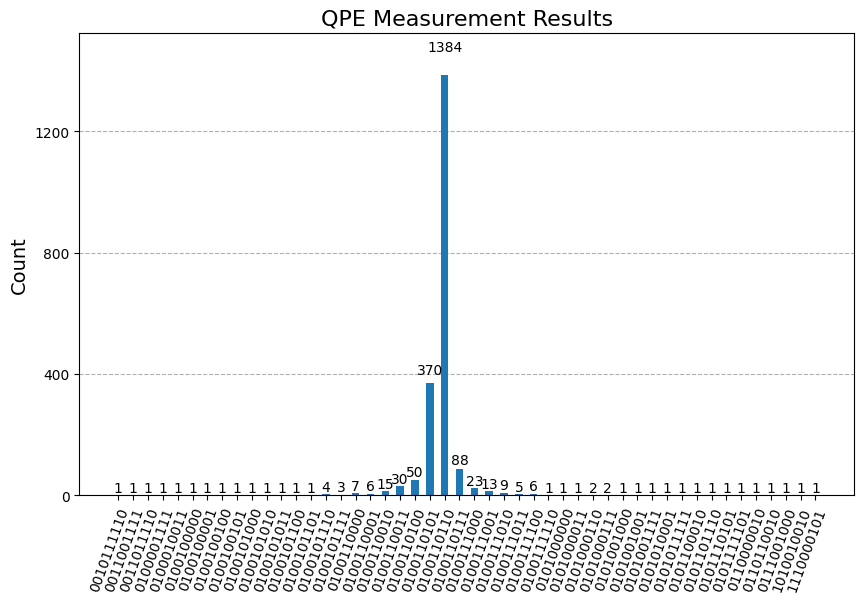


--- 생성된 양자 회로 ---
            ░ ┌───┐                                                          »
 q_0: ──────░─┤ H ├─────■────────────────────────────────────────────────────»
            ░ ├───┤     │                                                    »
 q_1: ──────░─┤ H ├─────┼──────────■─────────────────────────────────────────»
            ░ ├───┤     │          │                                         »
 q_2: ──────░─┤ H ├─────┼──────────┼──────────■──────────────────────────────»
            ░ ├───┤     │          │          │                              »
 q_3: ──────░─┤ H ├─────┼──────────┼──────────┼───────────■──────────────────»
            ░ ├───┤     │          │          │           │                  »
 q_4: ──────░─┤ H ├─────┼──────────┼──────────┼───────────┼───────────■──────»
            ░ ├───┤     │          │          │           │           │      »
 q_5: ──────░─┤ H ├─────┼──────────┼──────────┼───────────┼───────────┼──────»
            ░ ├───┤     │        

In [6]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.circuit.library import QFT
import matplotlib.pyplot as plt
from qiskit.visualization import plot_histogram

omega_true = 3.8  
t = 1.0        

n_counting_qubits = 10


def create_qpe_precession_circuit(n_counting, t, omega):

    qc = QuantumCircuit(n_counting + 1, n_counting)

    qc.x(n_counting)
    qc.barrier()

    for i in range(n_counting):
        qc.h(i)

    for i in range(n_counting):
        angle = omega * t * (2**i)
        qc.crz(angle, control_qubit=i, target_qubit=n_counting)
    qc.barrier()

    iqft_gate = QFT(n_counting, inverse=True)
    qc.append(iqft_gate, qc.qubits[:n_counting])
    qc.barrier()

    qc.measure(range(n_counting), range(n_counting))

    return qc


qpe_circuit = create_qpe_precession_circuit(n_counting_qubits, t, omega_true)

simulator = AerSimulator()
t_qpe_circuit = transpile(qpe_circuit, simulator)
result = simulator.run(t_qpe_circuit, shots=2048).result()
counts = result.get_counts()

most_probable_measurement = max(counts, key=counts.get)
k = int(most_probable_measurement, 2)

print(most_probable_measurement)


omega_estimated = (4 * np.pi * k) / (t * (2**n_counting_qubits))

print(f"QPE로 추정한 진동수 (ω_est): {omega_estimated:.4f} rad/s")

error = abs(omega_true - omega_estimated)
print(f"오차: {error:.4f} rad/s")


fig, ax = plt.subplots(figsize=(10, 6))
plot_histogram(counts, ax=ax)
ax.set_title("QPE Measurement Results", fontsize=16)
plt.show()

print("\n--- 생성된 양자 회로 ---")
print(qpe_circuit)